# Importing packages

First we need to import our necessary packages:

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from scipy import stats
from sklearn.preprocessing import StandardScaler
from time import time

# Reading our data

In this case, we will assume we know nothing about our data, so we will read it in as a raw text file, explore it and then parse it into a format that is suitable for a pandas DataFrame:

In [2]:
rawData = open('SMSSpamCollection.tsv').read()
rawData[:300]

"ham\tI've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.\nspam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receiv"

As we can see, we have labels ('ham' and 'spam') preceding "\t", and "\n" preceding the labels. 

We can go about this by replacing "\n" by "\t" and splitting on "\t" to separate labels from text:

In [3]:
rawData = rawData.replace('\n','\t').split('\t')
rawData[:20]

['ham',
 "I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.",
 'spam',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'ham',
 "Nah I don't think he goes to usf, he lives around here though",
 'ham',
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 'ham',
 'I HAVE A DATE ON SUNDAY WITH WILL!!',
 'ham',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'spam',
 'WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'spam',
 'Had your mobile 11 months or more? U R entitled to Upd

Here we can see we have a list in which evey other string is a label starting from index 0. So let us separate labels from text:

In [4]:
labels = rawData[0::2]
text = rawData[1::2]
print(labels[:4]), print(text[:4]);

['ham', 'spam', 'ham', 'ham']
["I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.", "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", "Nah I don't think he goes to usf, he lives around here though", 'Even my brother is not like to speak with me. They treat me like aids patent.']


Beautiful!! Now, we create our pandas DataFrame.

Before we can do that, we need to make sure both lists have the same length:

In [5]:
len(labels),len(text)

(5571, 5570)

`labels` has one more string than text. Let's check the very last string:

In [6]:
labels[-1], text[-1]

('', 'Rofl. Its true to its name')

This makes sense. Remember that at the end of every text (before every label) we had "\n"? When we split on "\n", it took the very last "\n" and returned an empty string into `labels`. Let us get rid of it and proceed with our DataFrame:

In [7]:
labels.pop()
data = pd.DataFrame({'labels': labels, 'text': text})
data

,labels,text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
...,...,...
5565,spam,This is the 2nd time we have tried 2 contact u...
5566,ham,Will Ã¼ b going to esplanade fr home?
5567,ham,"Pity, * was in mood for that. So...any other s..."
5568,ham,The guy did some bitching but I acted like i'd...


### The easy way:

From our file `SMSSpamCollection.tsv` we can see it is a '.tsv' (tab separated values). Pandas is able to read this type of files as:

In [8]:
pd.read_csv('SMSSpamCollection.tsv', delimiter='\t', header=None, names=['label','text'])

,label,text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
...,...,...
5563,spam,This is the 2nd time we have tried 2 contact u...
5564,ham,Will ü b going to esplanade fr home?
5565,ham,"Pity, * was in mood for that. So...any other s..."
5566,ham,The guy did some bitching but I acted like i'd...


# Exploratory Data Analysis:

Before we can apply any type of ML, we need to understand the data we are working with:

In [9]:
data.shape

(5570, 2)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  5570 non-null   object
 1   text    5570 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Great! No missing values. 

How many observations of each label do we have?

In [11]:
print(data.labels.value_counts())
print(f"% of spam: {round(100*data.labels.value_counts()[1]/len(data),2)}%")

ham     4824
spam     746
Name: labels, dtype: int64
% of spam: 13.39%


Since we have a DataFrame with only two features, one of them being the target variable, and the predictor variable is all text, there is not much we can do in EDA (other than making sure our data is clean and tidy, which comes later). So now, we can move forward into Feature Engineering.

# Feature Engineering

Let's identify possible features we can extract from our data that might help our model make better decision:
- Length of text
- Amount of uppercase letters
- Amount of punctuation
- Exploring our features
- Transforming features (if needed)

### Length of text

Here we just take our raw text and count the amount of characters keeping in mind the whitespaces:

In [12]:
data['text_len'] = data.text.apply(lambda x: len(x) - len(re.findall('\s',x)))
data.head()

,labels,text,text_len
0,ham,I've been searching for the right words to tha...,160
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128
2,ham,"Nah I don't think he goes to usf, he lives aro...",49
3,ham,Even my brother is not like to speak with me. ...,62
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28


### Amount of uppercase letters

Similarly to text_len, we want to count how many uppercase letters there are in each observation:

In [13]:
data['upper_count'] = data.text.apply(lambda x: sum([1 for char in x if char.isupper()]))
data.head()

,labels,text,text_len,upper_count
0,ham,I've been searching for the right words to tha...,160,3
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,10
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,2
3,ham,Even my brother is not like to speak with me. ...,62,2
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,26


### Amount of punctuation

You know the deal, but we will use the built-in package 'string' to achieve our purpose::

In [14]:
data['punc_count'] = data.text.apply(lambda x: sum([1 for char in x if char in string.punctuation]))
data.head()

,labels,text,text_len,upper_count,punc_count
0,ham,I've been searching for the right words to tha...,160,3,4
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,10,6
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,2,2
3,ham,Even my brother is not like to speak with me. ...,62,2,2
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,26,2


### Exploring our features

By exploring our features we can have an idea of any trends that might be obvious in spam messages, however, feature selection is a task we will leave for later:

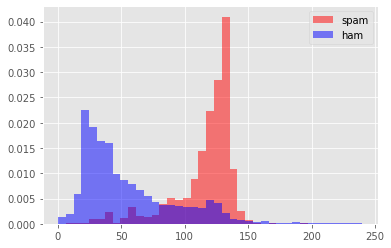

In [15]:
bins=np.linspace(0,240,40)
plt.hist(data[data.labels == 'spam'].text_len, bins, alpha = 0.5, color = 'r', density=True, label='spam')
plt.hist(data[data.labels == 'ham'].text_len, bins, alpha = 0.5, color = 'b', density=True, label='ham')
plt.legend(loc='upper right')
plt.show()

Here we can see a clear difference between `spam` and `ham`. This variable could potentially be very usefull for the model.

Now let's explore the amount of uppercase letters:

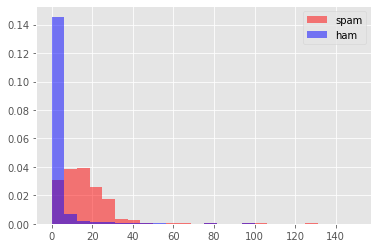

In [16]:
bins=np.linspace(0,150,25)
plt.hist(data[data.labels == 'spam'].upper_count, bins, alpha = 0.5, color = 'r', density=True, label='spam')
plt.hist(data[data.labels == 'ham'].upper_count, bins, alpha = 0.5, color = 'b', density=True, label='ham')
plt.legend(loc='upper right')
plt.show()

`ham` has less uppercase letters on average. However, there are some outliers on both labels so this featuer might not be that useful.

Now, amount of punctuation:

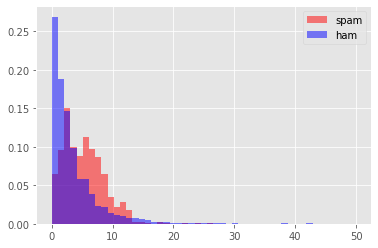

In [17]:
bins=np.linspace(0,50,50)
plt.hist(data[data.labels == 'spam'].punc_count, bins, alpha = 0.5, color = 'r', density=True, label='spam')
plt.hist(data[data.labels == 'ham'].punc_count, bins, alpha = 0.5, color = 'b', density=True, label='ham')
plt.legend(loc='upper right')
plt.show()

Again, this feature might not be useful as it doesn't tell much.

### Feature transformation

Let's look at our features individually and determine what kind of distribution they have:

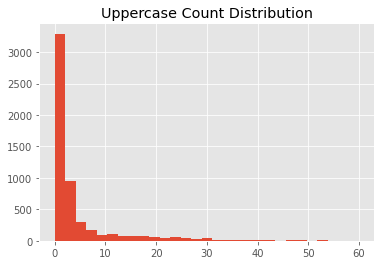

In [18]:
plt.hist(data.upper_count, bins=np.linspace(0,60,30))
plt.title('Uppercase Count Distribution')
plt.show()

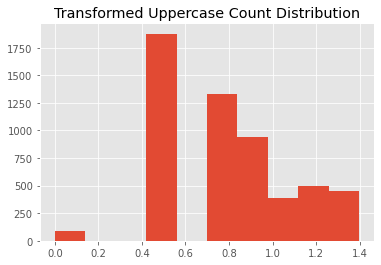

In [19]:
data.upper_count = stats.boxcox(data.upper_count+1)[0]
plt.hist(data.upper_count)
plt.title('Transformed Uppercase Count Distribution')
plt.show()

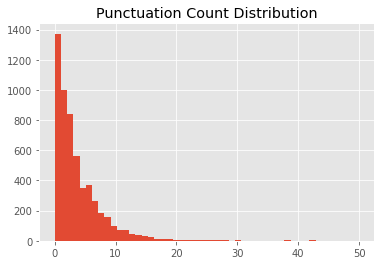

In [20]:
plt.hist(data.punc_count, bins=np.linspace(0,50,50))
plt.title('Punctuation Count Distribution')
plt.show()

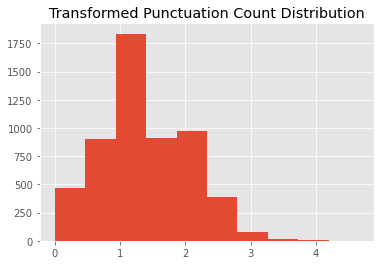

In [21]:
data.punc_count = stats.boxcox(data.punc_count+1)[0]
plt.hist(data.punc_count)
plt.title('Transformed Punctuation Count Distribution')
plt.show()

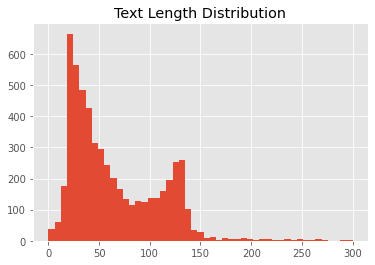

In [22]:
plt.hist(data.text_len, bins=np.linspace(0,300,50))
plt.title('Text Length Distribution')
plt.show()

Punctuation and Uppercase count are heavily skewed. Text Length has a bimodal distribution and might not need to be transformed. Regardless of which needs to be transformed, we will take care of that in the modeling section.

# Pre-Processing

For our Machine Learning pipeline we need to make sure we take care of:
- Removing punctuation
- Tokenization
- Remove stopwords
- Stemming
- Lemmatizing
- Vectorizing

### Removing punctuation

We will use the built-in package 'string' to achieve our purpose:

In [23]:
data['no_punc'] = data.text.apply(lambda x: [char for char in x if char not in string.punctuation])
data.head()

,labels,text,text_len,upper_count,punc_count,no_punc
0,ham,I've been searching for the right words to tha...,160,0.892113,1.583538,"[I, v, e, , b, e, e, n, , s, e, a, r, c, h, ..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,1.171564,1.908134,"[F, r, e, e, , e, n, t, r, y, , i, n, , 2, ..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,0.769940,1.086503,"[N, a, h, , I, , d, o, n, t, , t, h, i, n, ..."
3,ham,Even my brother is not like to speak with me. ...,62,0.769940,1.086503,"[E, v, e, n, , m, y, , b, r, o, t, h, e, r, ..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,1.299301,1.086503,"[I, , H, A, V, E, , A, , D, A, T, E, , O, ..."


Here we have removed all punctuations, but our lambda function returned each character individually as opposed to returning the words we passed it. In order to get our words back, we can join the characters on '' (empty space) which were the white spaces before:

In [24]:
data['no_punc'] = data.text.apply(lambda x: "".join([char for char in x if char not in string.punctuation]))
data.head()

,labels,text,text_len,upper_count,punc_count,no_punc
0,ham,I've been searching for the right words to tha...,160,0.892113,1.583538,Ive been searching for the right words to than...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,1.171564,1.908134,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,0.769940,1.086503,Nah I dont think he goes to usf he lives aroun...
3,ham,Even my brother is not like to speak with me. ...,62,0.769940,1.086503,Even my brother is not like to speak with me T...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,1.299301,1.086503,I HAVE A DATE ON SUNDAY WITH WILL


### Tokenization

In our previous steps we went from a full string with punctuations to a full string without punctuations. Now we want to turn each word into a separate string in a list of strings. Note that we could have done that in the same step where we removed punctuation by changing the lambda function to:

In [25]:
data.text.apply(lambda x: "".join([char.lower() for char in x if char not in string.punctuation]).split())

0       [ive, been, searching, for, the, right, words,...
1       [free, entry, in, 2, a, wkly, comp, to, win, f...
2       [nah, i, dont, think, he, goes, to, usf, he, l...
3       [even, my, brother, is, not, like, to, speak, ...
4              [i, have, a, date, on, sunday, with, will]
                              ...                        
5565    [this, is, the, 2nd, time, we, have, tried, 2,...
5566        [will, ã¼, b, going, to, esplanade, fr, home]
5567    [pity, was, in, mood, for, that, soany, other,...
5568    [the, guy, did, some, bitching, but, i, acted,...
5569                     [rofl, its, true, to, its, name]
Name: text, Length: 5570, dtype: object

But for the sake of separating each step, we will do it as:

In [26]:
data['tokens'] = data.no_punc.apply(lambda x: [x.lower() for x in re.split('\W+',x)])
data.head()

,labels,text,text_len,upper_count,punc_count,no_punc,tokens
0,ham,I've been searching for the right words to tha...,160,0.892113,1.583538,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,1.171564,1.908134,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,0.769940,1.086503,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
3,ham,Even my brother is not like to speak with me. ...,62,0.769940,1.086503,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,1.299301,1.086503,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]"


### Remove stopwords

To remove stopwords, nltk package has a list of stopwords per language:

In [27]:
print(len(nltk.corpus.stopwords.words('english'))), print(nltk.corpus.stopwords.words('english')[:10]);

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [28]:
print(len(nltk.corpus.stopwords.words('spanish'))), print(nltk.corpus.stopwords.words('spanish')[:10]);

313
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


Fun fact: Spanish has 134 more stopwords than english.

Now, we apply the same lambda function but instead of punctuations, we compare them to stopwords:

In [29]:
stopwords = nltk.corpus.stopwords.words('english')
data['no_stop'] = data.tokens.apply(lambda x: [word for word in x if word not in stopwords])
data.head()

,labels,text,text_len,upper_count,punc_count,no_punc,tokens,no_stop
0,ham,I've been searching for the right words to tha...,160,0.892113,1.583538,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,...","[ive, searching, right, words, thank, breather..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,1.171564,1.908134,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,0.769940,1.086503,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
3,ham,Even my brother is not like to speak with me. ...,62,0.769940,1.086503,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,1.299301,1.086503,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]","[date, sunday]"


### Stemming

What stemming does is removing the last few letters of a word so they are generalized. For example: learning, learned and learn are all stemmed so they look like 'learn'.

This process makes it easier for the model as it doesn't need to deal with as many words that potentially mean the same thing.

For stemming we will use the NLTK PorterStemmer:

In [30]:
ps = nltk.PorterStemmer()

Let us see a simple example of how this works:

In [31]:
print(ps.stem('grow'), ps.stem('grows'), ps.stem('growing'))

grow grow grow


In [32]:
data['stemmed'] = data.no_stop.apply(lambda x: [ps.stem(word) for word in x])
data.head()

,labels,text,text_len,upper_count,punc_count,no_punc,tokens,no_stop,stemmed
0,ham,I've been searching for the right words to tha...,160,0.892113,1.583538,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,...","[ive, searching, right, words, thank, breather...","[ive, search, right, word, thank, breather, pr..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,1.171564,1.908134,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,0.769940,1.086503,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."
3,ham,Even my brother is not like to speak with me. ...,62,0.769940,1.086503,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids...","[even, brother, like, speak, treat, like, aid,..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,1.299301,1.086503,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]"


### Lemmatizing

Lemmatizing and Stemming actually accomplish the same thing. The main differences are:
- Stemming requires less computational power than Lemmatizing
- Lemmatizing always returns a dictionary word, as opposed to Stemming where it 'chops off' the last few letters of the word returning words that might not exist (e.g 'Entries' & 'Entry' = 'Entri'

For lemmatizing, we will use NLTK WordNetLemmatizer:


In [33]:
wn=nltk.WordNetLemmatizer()
print(ps.stem('entries'), ps.stem('entry'))
print(wn.lemmatize('entries'), wn.lemmatize('entry'))

entri entri
entry entry


In [34]:
data['lemmatized'] = data.no_stop.apply(lambda x: [wn.lemmatize(word) for word in x])
data.head()

,labels,text,text_len,upper_count,punc_count,no_punc,tokens,no_stop,stemmed,lemmatized
0,ham,I've been searching for the right words to tha...,160,0.892113,1.583538,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,...","[ive, searching, right, words, thank, breather...","[ive, search, right, word, thank, breather, pr...","[ive, searching, right, word, thank, breather,..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,1.171564,1.908134,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,0.769940,1.086503,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"
3,ham,Even my brother is not like to speak with me. ...,62,0.769940,1.086503,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids...","[even, brother, like, speak, treat, like, aid,...","[even, brother, like, speak, treat, like, aid,..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,1.299301,1.086503,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]","[date, sunday]"


As you can see, lemmatizing is usually a more robust way of tackling this part if computational power is not limiting your ML model.

So far we did everything in individual steps. In the real world we will want to create a pipeline where you can feed it the raw dataframe and it returns a dataframe that is ready for modeling:

In [35]:
def clean_data(df):
    df['no_punc'] = df.text.apply(lambda x: "".join([char for char in x if char not in string.punctuation]))
    df['tokens'] = df.no_punc.apply(lambda x: [x.lower() for x in re.split('\W+',x)])
    df['no_stop'] = df.tokens.apply(lambda x: [word for word in x if word not in stopwords])
    df['lemmatized'] = df.no_stop.apply(lambda x: [wn.lemmatize(word) for word in x])
    return df

In [36]:
#data = clean_data(pd.DataFrame({'labels':labels, 'text':text}))
#data
#not running it because erases engineered features

As you can see, that simple function achieves exactly what we have done so far (except stemming which we won't be using in this project).

SkLearn provides a function to automatically do what we just did (CountVectorizer), however, the default parameters do not give you much control over how your data is parsed.

Below we can see the shape of the matrix it returns:

In [37]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(data.text)
print(X_counts.shape)

(5570, 8749)


Fortunally, CountVectorizer also gives you the option to pass it your own function and take control of how your data is parsed. For this, let us defined a very similar function that lemmatizes our raw text and returns a list of different words.

`Note: We can manually vectorize our data['lemmatized'] column by running a for loop and checking each component of the list and creating a new variable if it doesn't exist, or adding one to that column if already exists`

That being said, we can re-write our `clean_data` function to return a list of lemmatized words:

In [38]:
def clean_text(text):
   
    no_punc = "".join([char for char in text if char not in string.punctuation])
    tokens = [no_punc.lower() for no_punc in re.split('\W+', no_punc)]
    no_stop = [word for word in tokens if word not in stopwords]
    lemmatized = [wn.lemmatize(word) for word in no_stop]
    return lemmatized

In [39]:
count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(data.text)
print(X_counts.shape)

(5570, 8958)


As you can see, the vectorizer returns a bigger array.

Now, let's turn our vector into a dataframe:

In [40]:
X_counts_df = pd.DataFrame(X_counts.toarray(), columns = count_vect.get_feature_names())
X_counts_df.head()

,,0,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,...,zyada,¾ã,â,ã,ã¼,ã¼ll,ãœ,ãœll,œ,œharry
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's also create a TfidfVectorizer to compare with CountVectorizer when modeling:

In [41]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data.text)
print(X_tfidf.shape)

(5570, 8958)


In [42]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf_vect.get_feature_names())
X_tfidf_df.sample(5)

,,0,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,...,zyada,¾ã,â,ã,ã¼,ã¼ll,ãœ,ãœll,œ,œharry
2034,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1460,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.579388,0.0,0.000000,0.0,0.0,0.0
4218,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1691,0.144418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.458152,0.0,0.0,0.0
4402,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


# Modeling

We will try 3 different models:

- Random Forest
- XGboost
- SVM

First, let's put our dataframes together:

In [43]:
X_counts_df = pd.concat([X_counts_df,data[['punc_count','text_len','upper_count']]],axis=1)

In [44]:
X_tfidf_df = pd.concat([X_tfidf_df,data[['punc_count','text_len','upper_count']]],axis=1)

In [45]:
#Splitting X_counts_df
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_counts_df, data.labels, test_size=0.25, random_state=42)
#Splitting X_tfidf_df
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_tfidf_df, data.labels, test_size=0.25, random_state=42)

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
clf_c = RandomForestClassifier(n_jobs=-1)
clf_c.fit(X_train_c, y_train_c)
y_pred_c = clf_c.predict(X_test_c)

<AxesSubplot:>

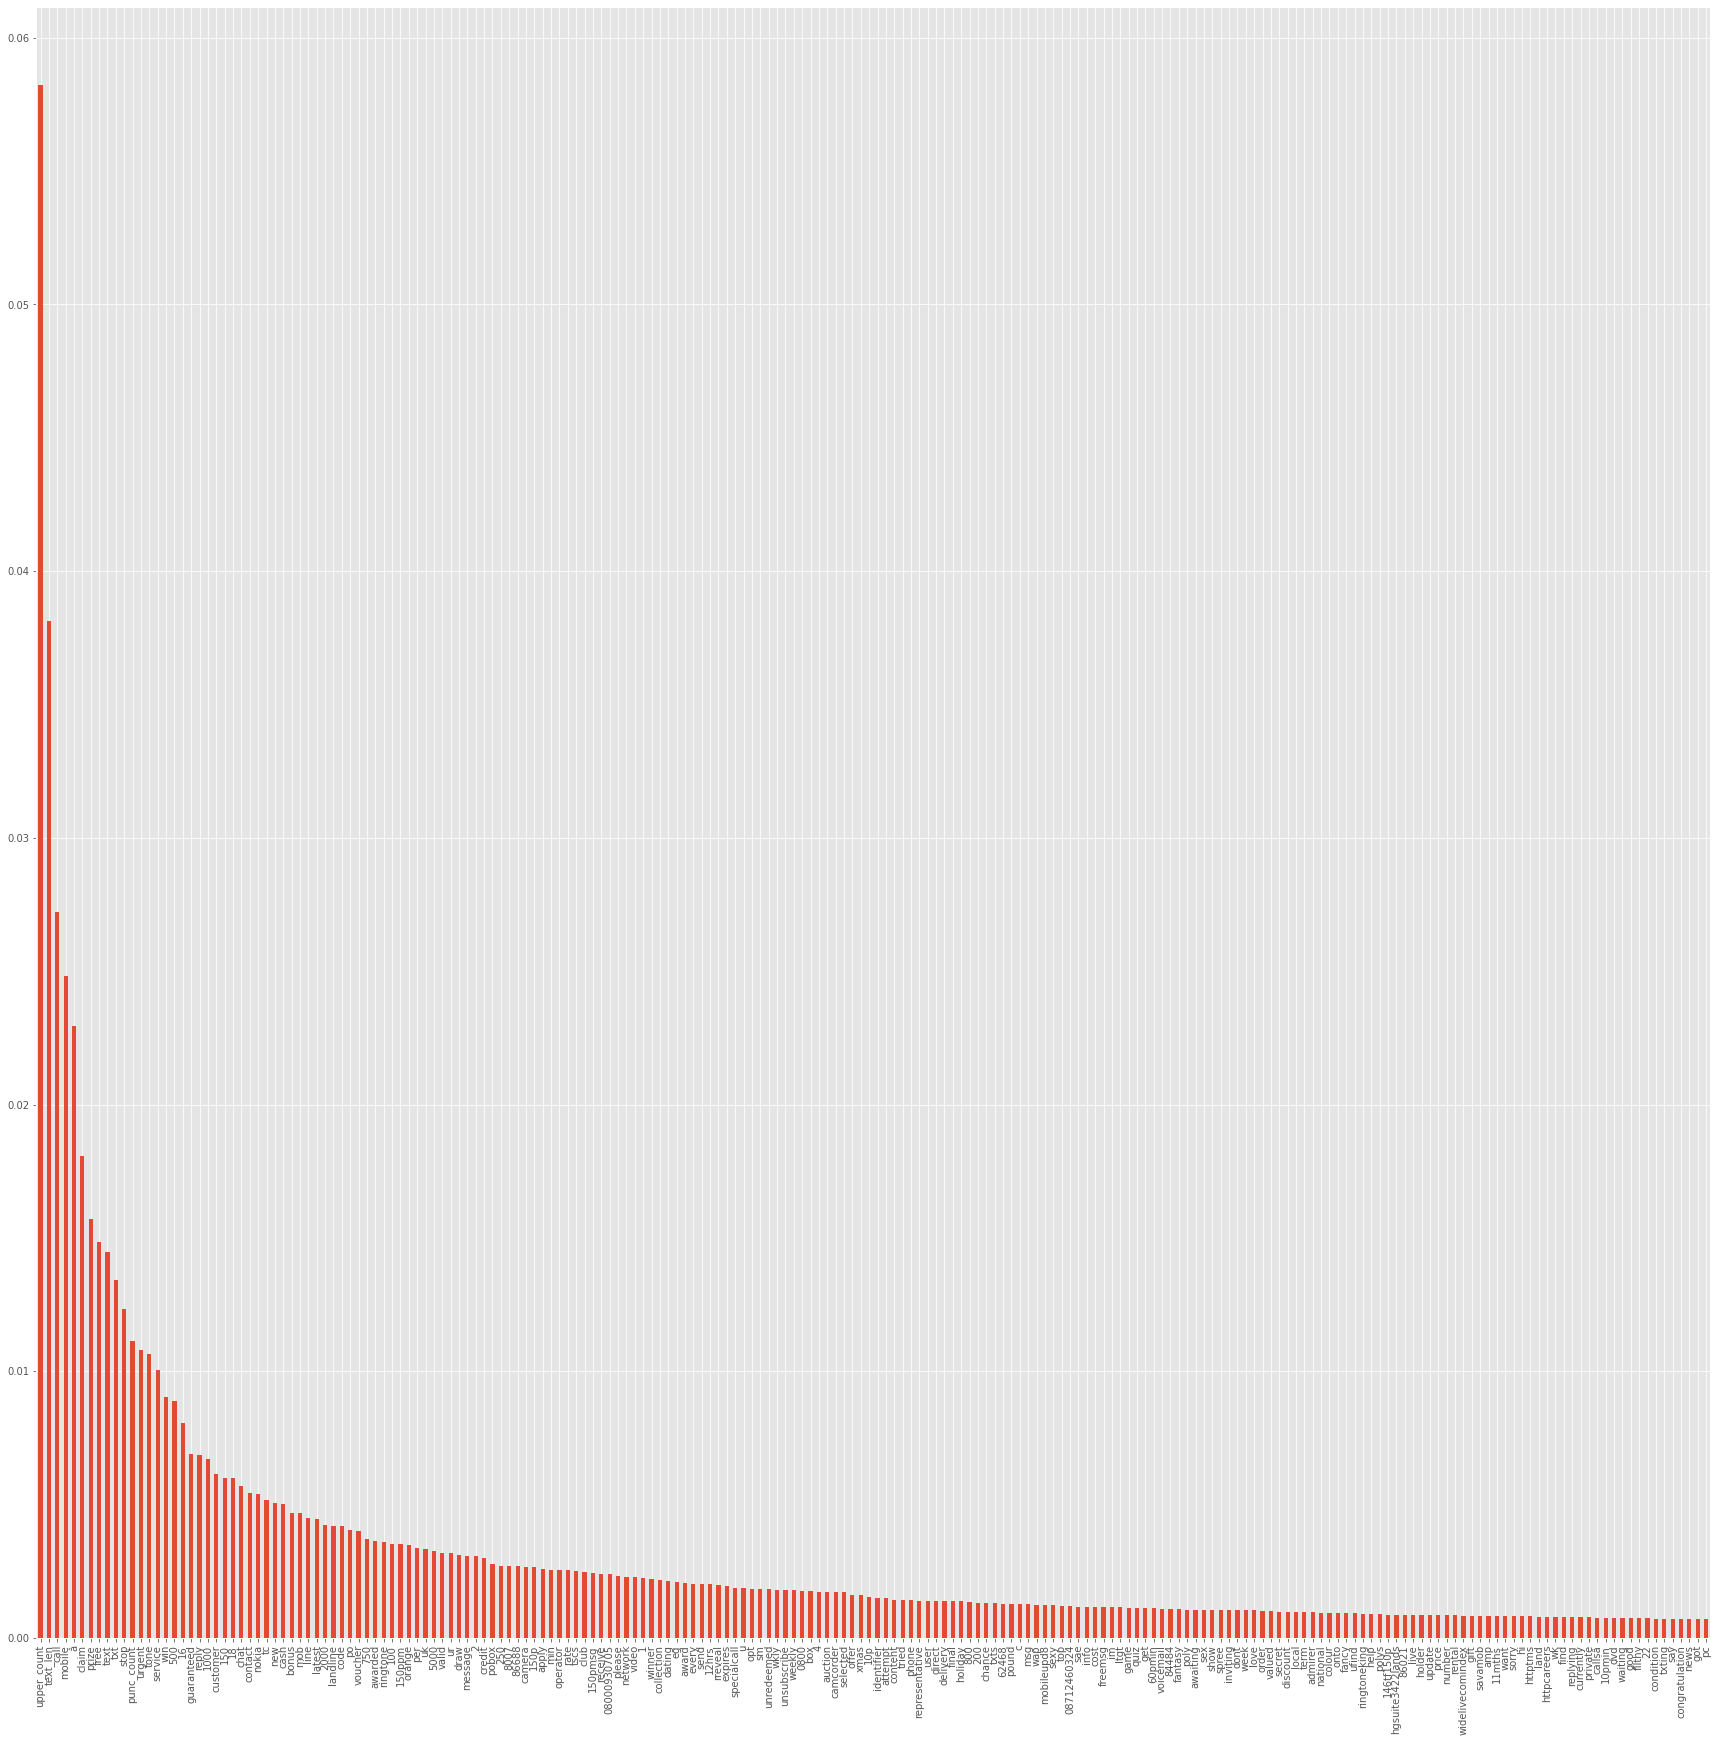

In [47]:
plt.figure(figsize=(30,30))
pd.Series(clf_c.feature_importances_, index=X_train_c.columns).sort_values(ascending=False)[:200].plot(kind='bar')

In [48]:
score = classification_report(y_test_c, y_pred_c)
print(score)

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1205
        spam       1.00      0.81      0.90       188

    accuracy                           0.97      1393
   macro avg       0.99      0.91      0.94      1393
weighted avg       0.98      0.97      0.97      1393



Here we see `upper_count` is the most important variable. `text_len` comes in second and `punc_count` somewhere around 10th. Our feature engineering paid off!!!

Alse, these are pretty good scores. Let's run a cross-validation on this model:

In [49]:
cross_validate(clf_c, X_train_c, y_train_c, cv=5)

{'fit_time': array([3.92766523, 2.16340089, 1.97557998, 1.9510026 , 1.9687438 ]),
 'score_time': array([0.09002042, 0.08801937, 0.09002042, 0.0900209 , 0.08902001]),
 'test_score': array([0.97248804, 0.97966507, 0.97005988, 0.97245509, 0.9760479 ])}

Right off the bat we get pretty good scores for the random forest classifier using the CountVectorizer dataframe, let's try with the TfidfVectorizer:

In [50]:
clf_t = RandomForestClassifier(n_jobs=-1)
clf_t.fit(X_train_t, y_train_t)
y_pred_t = clf_t.predict(X_test_t)
print(classification_report(y_test_t, y_pred_t))


              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1205
        spam       1.00      0.82      0.90       188

    accuracy                           0.98      1393
   macro avg       0.99      0.91      0.95      1393
weighted avg       0.98      0.98      0.98      1393



In [51]:
cross_validate(clf_t, X_train_t, y_train_t, cv=5)

{'fit_time': array([1.96765661, 2.0255146 , 1.99416971, 1.92043471, 1.91408825]),
 'score_time': array([0.08801174, 0.08701181, 0.08902001, 0.08801985, 0.08902001]),
 'test_score': array([0.97488038, 0.98205742, 0.96646707, 0.97005988, 0.97964072])}

First thing to note is that the TfidfVectorizer makes the model almost twice as slow as the CountVectorizer. The scores are pretty much the same, so for RandomForest we will stick with CountVerctorizer. 

Let's create a pipeline with to run a GridSearchCV and try different parameters:

In [52]:
rf_c =make_pipeline(StandardScaler(),RandomForestClassifier(random_state=42, n_jobs=-1))

In [53]:
n_est = [10,100,500]
grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'randomforestclassifier__max_depth' : [3,10,50,100, None]
        }
rf_grid_cv = GridSearchCV(rf_c, param_grid=grid_params, cv=3, n_jobs=-1)

In [54]:
rf_grid_cv.fit(X_train_c, y_train_c)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [3, 10, 50, 100,
                                                               None],
                         'randomforestclassifier__n_estimators': [10, 100, 500],
                         'standardscaler': [StandardScaler(), None]})

In [55]:
print(rf_grid_cv.best_params_)
print(rf_grid_cv.best_estimator_)

{'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 100, 'standardscaler': StandardScaler()}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])


Here we can see that our best classifier has 100 estimators (100 estimators is the default for RandomForestClassifier). Also, applying StandardScaler to our variables seems to help the model, and no max_depth.

In [56]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train_c, y_train_c, cv=3)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.97200287, 0.97557471, 0.97485632])

In [57]:
print(classification_report(y_test_c, rf_grid_cv.predict(X_test_c)))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1205
        spam       1.00      0.81      0.89       188

    accuracy                           0.97      1393
   macro avg       0.99      0.90      0.94      1393
weighted avg       0.97      0.97      0.97      1393



Results are pretty comparable to our first model.

<AxesSubplot:>

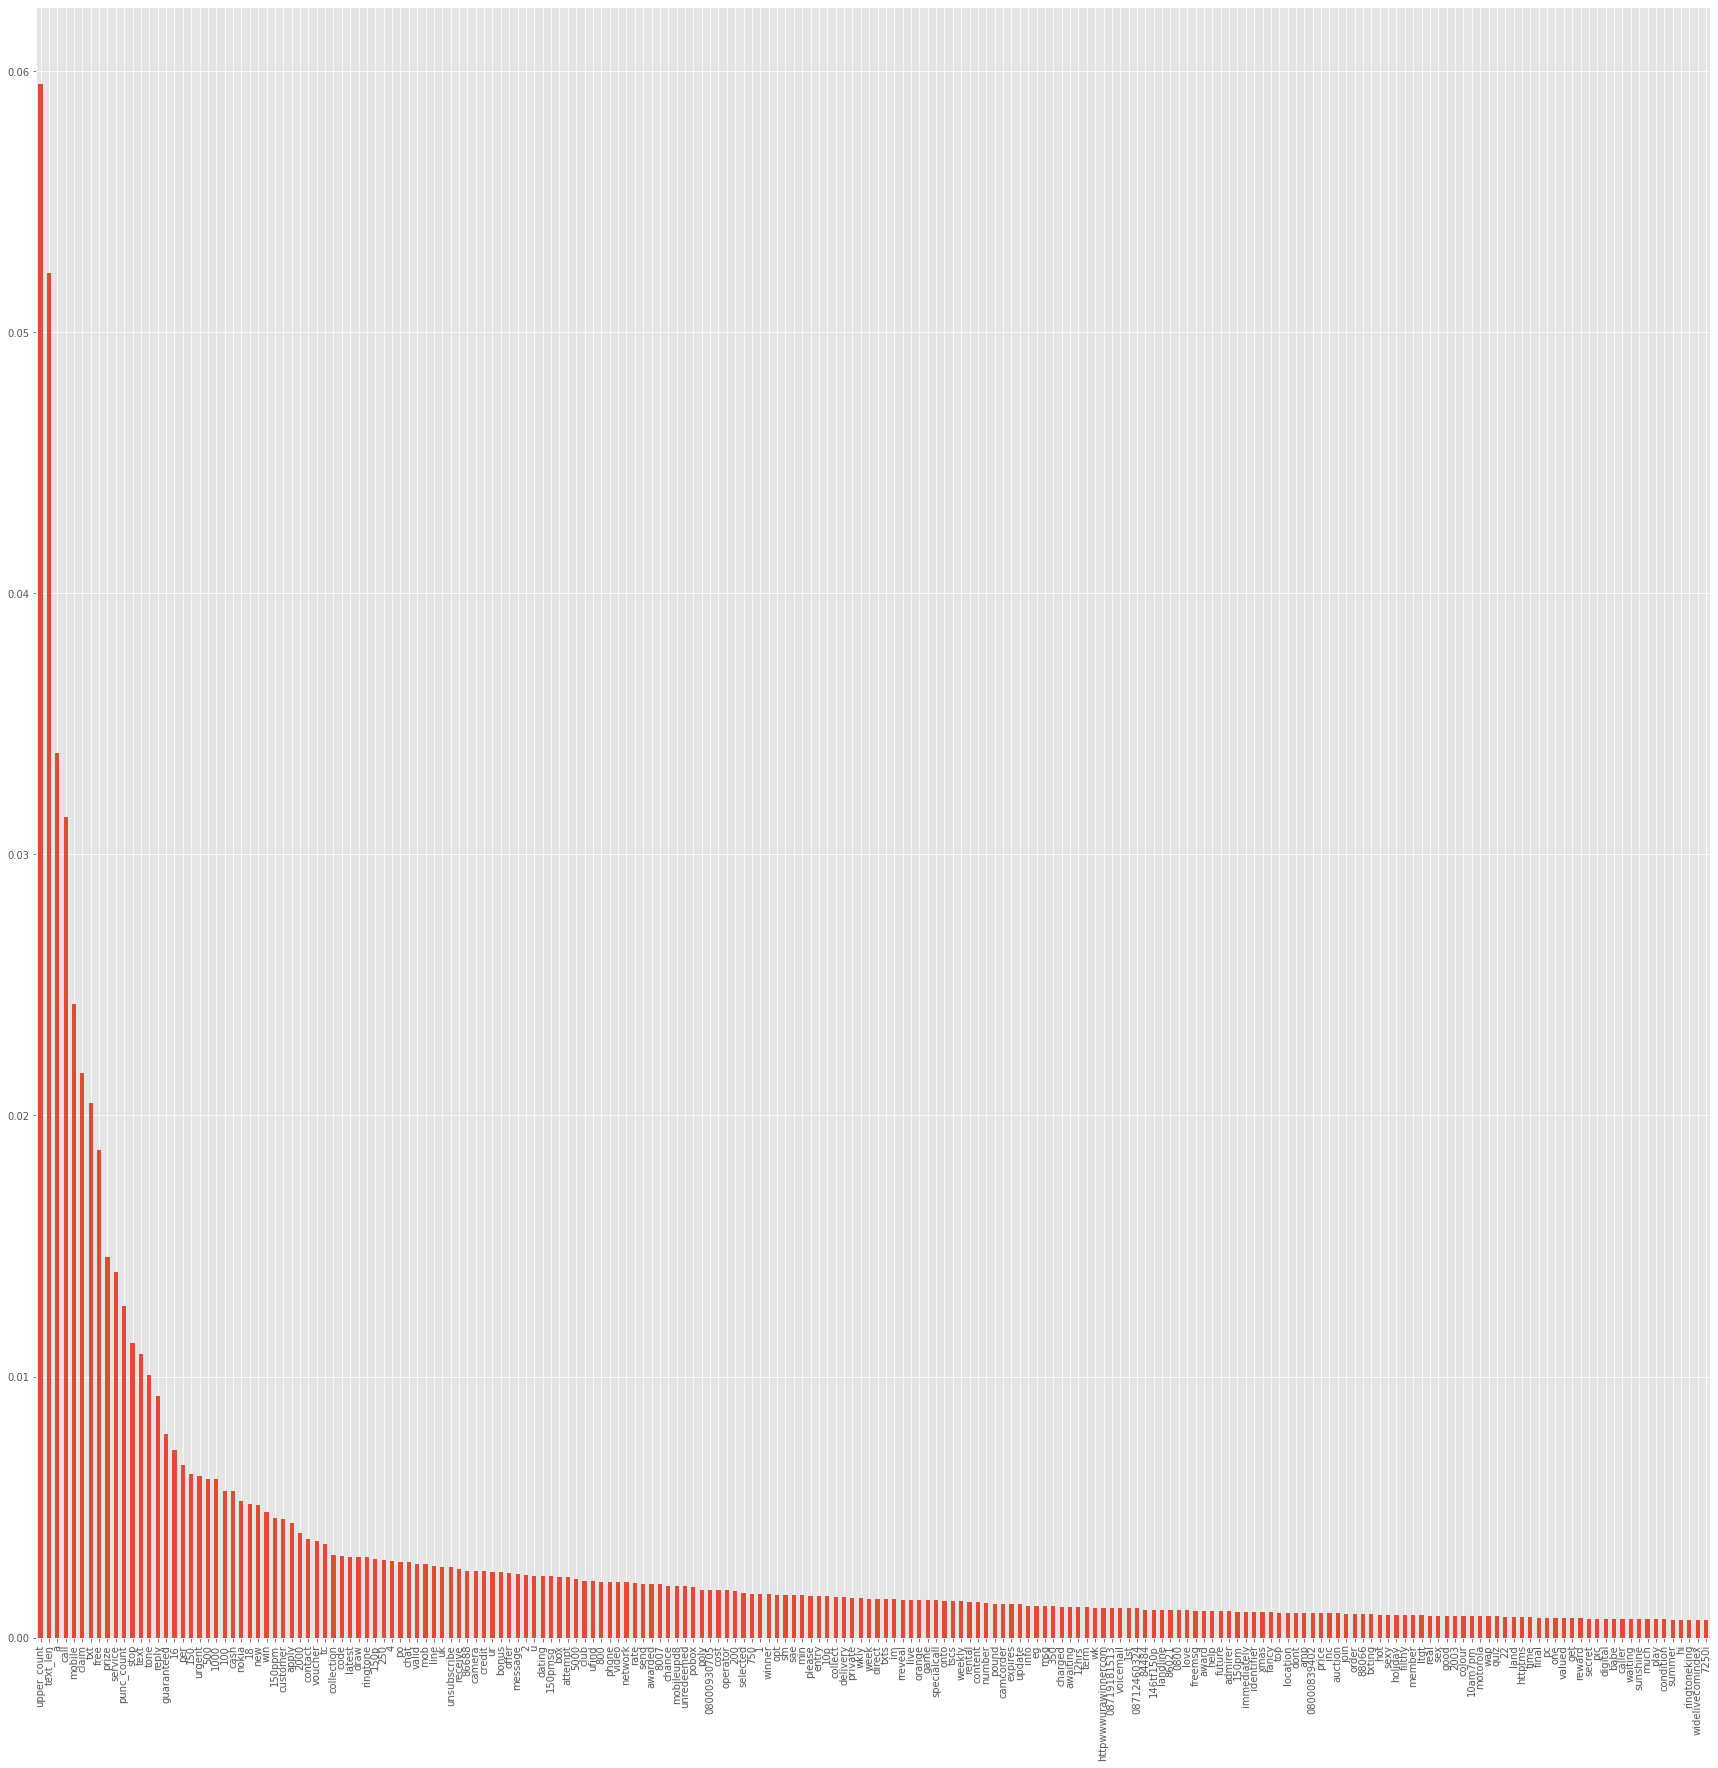

In [58]:
plt.figure(figsize=(30,30))
pd.Series(rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_, index=X_train_c.columns).sort_values(ascending=False)[:200].plot(kind='bar')

Again, our engineered features come in in the first most important variables. Sweet!!

# XGBoost

In [59]:
import xgboost as xgb
xg_cl = xgb.XGBClassifier(objective='reg:logistic', n_estimators=100, seed=123)

In [ ]:
xg_cl.fit(X_train_c, y_train_c)
xgb_pred = xg_cl.predict(X_test_c)

In [61]:
print(classification_report(y_test_t, xgb_pred))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1205
        spam       0.97      0.87      0.92       188

    accuracy                           0.98      1393
   macro avg       0.97      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393



Xgboost seems to perform slightly worse than RandomForest. We do have a better score for `recall` but in this instance, `precision` is more important, since we want mail classified as `spam` to actually be `spam`. We can deal with `spam` classified as `ham`, but `ham` classified as `spam` is not good.

Let's look at the most important features:

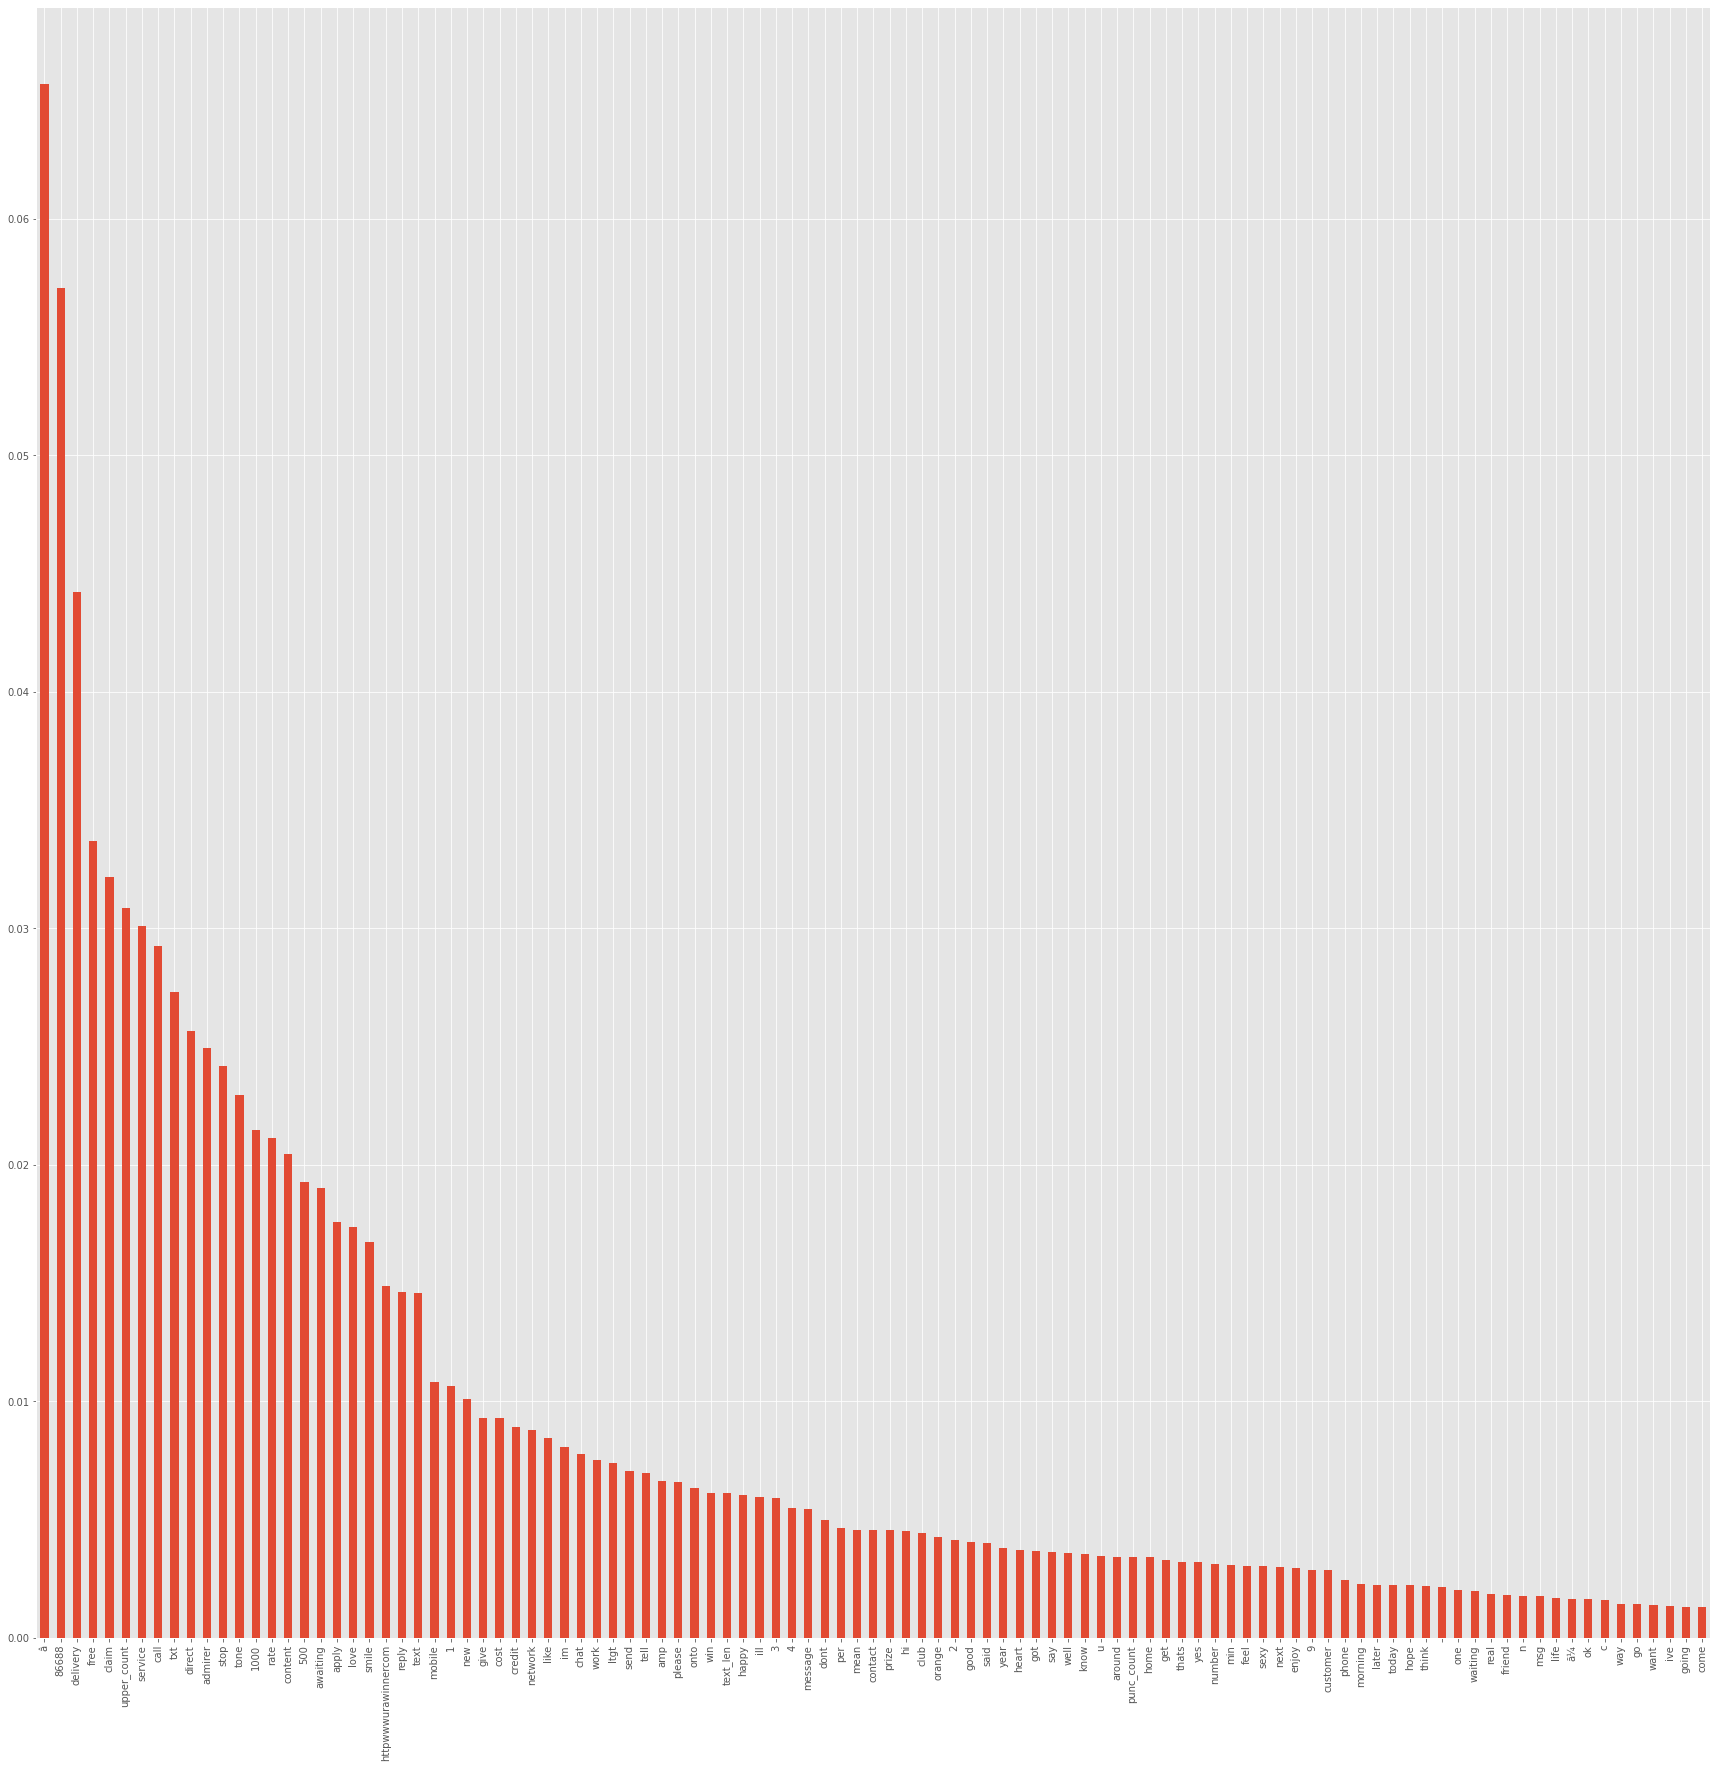

In [62]:
plt.figure(figsize=(30,30))
pd.Series(xg_cl.feature_importances_, index=X_train_c.columns).sort_values(ascending=False)[:103].plot(kind='bar');
plt.show()

Again, our features made it into the most important features.

Let's try and tune our xgboost model to see if we can do better than RandomForest:

### This is as a markdown because it takes too long to compute. Results are copied down.
xg_clf = xgb.XGBClassifier(objective='reg:logistic', seed=123)
params= {
    'n_estimators': [100,200],
    'learning_rate': [0.01,0.1,0.5,0.9],
    'max_depth': [100,None]
    
}
xg_grid_cv = GridSearchCV(xg_clf, params,cv=3,verbose = 1)
xg_grid_cv.fit(X_train_c,y_train_c)

{'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 200}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1,
              objective='reg:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgb_pred = xg_grid_cv.predict(X_test_c)
print(classification_report(y_test_t, xgb_pred))
      precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1205
        spam       0.97      0.86      0.91       188

    accuracy                           0.98      1393
   macro avg       0.97      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393


print(xg_grid_cv.best_params_)
print(xg_grid_cv.best_estimator_)


{'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 200}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1,
              objective='reg:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

plt.figure(figsize=(30,30))
pd.Series(xg_grid_cv.best_estimator_.feature_importances_, index=X_train_c.columns).sort_values(ascending=False)[:200].plot(kind='bar')
plt.show()

This model didn't perform better than our inital model. Now let's see if SVM can beat RandomForest:

### Support Vector Machine

In [63]:
from sklearn.svm import SVC

In [64]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_c, y_train_c)

SVC(random_state=42)

In [65]:
cross_validate(svm_clf, X_train_c, y_train_c, cv=5)

{'fit_time': array([12.28378296, 12.47282767, 12.27878451, 12.33279634, 12.52783942]),
 'score_time': array([4.34898615, 4.35898805, 4.42100191, 4.33598328, 4.33798409]),
 'test_score': array([0.89952153, 0.86602871, 0.9005988 , 0.87784431, 0.90658683])}

This model is about 6 times slower than our RandomForest. Let's look at out accuracy:

In [66]:
svm_pred = svm_clf.predict(X_test_c)
print(classification_report(y_test_t, svm_pred))

              precision    recall  f1-score   support

         ham       0.94      0.94      0.94      1205
        spam       0.60      0.62      0.61       188

    accuracy                           0.89      1393
   macro avg       0.77      0.78      0.77      1393
weighted avg       0.89      0.89      0.89      1393



Our score is pretty bad... Let's try GridSearchCV to tune our hyperparameters:

In [67]:
svm_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_grid_cv = GridSearchCV(SVC(random_state=42), svm_params, cv=3, n_jobs=-1)

In [68]:
svm_grid_cv.fit(X_train_c,y_train_c)

GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [69]:
print(svm_grid_cv.best_params_)
print(svm_grid_cv.best_estimator_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001, random_state=42)


In [70]:
svm_grid_pred = svm_grid_cv.predict(X_test_c)
print(classification_report(y_test_t, svm_grid_pred))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1205
        spam       0.95      0.85      0.90       188

    accuracy                           0.97      1393
   macro avg       0.96      0.92      0.94      1393
weighted avg       0.97      0.97      0.97      1393



By tunning our SVM, we got significantly better results, but this model is extremily slow giving the high amount of predictors and our first model is still better.

# Model Selection

So far we have been cheating. We vectorized all our data and then applied train/test split when in reality, we should fit the our vectorizer with the training data and transform our test data with the training data. We will do that and then evaluate our best model and see what scores we get:

### Splitting the data

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data[['text', 'text_len', 'upper_count', 'punc_count']], data.labels, test_size=0.25, random_state=42)

### Vectorizing the data

In [72]:
count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit(X_train.text)
count_train = count_vect.transform(X_train.text)
count_test = count_vect.transform(X_test.text)

In [73]:
X_train_vect =  pd.concat([X_train[['text_len', 'upper_count', 'punc_count']].reset_index(drop=True), pd.DataFrame(count_train.toarray(), columns = count_vect.get_feature_names())], axis=1)
X_train_vect.head()

,text_len,upper_count,punc_count,,0,008704050406,0089my,0121,01223585334,02,...,zogtorius,zoom,zouk,zyada,â,ã¼,ãœ,ãœll,œ,œharry
0,22,0.550827,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,0.550827,1.367050,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23,0.550827,0.688314,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,328,1.243335,3.255246,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,111,1.187684,2.499587,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
X_test_vect =  pd.concat([X_test[['text_len', 'upper_count', 'punc_count']].reset_index(drop=True), pd.DataFrame(count_test.toarray(), columns = count_vect.get_feature_names())], axis=1)
X_test_vect.head()

,text_len,upper_count,punc_count,,0,008704050406,0089my,0121,01223585334,02,...,zogtorius,zoom,zouk,zyada,â,ã¼,ãœ,ãœll,œ,œharry
0,128,1.251256,2.340706,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,41,0.769940,0.688314,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34,0.769940,1.583538,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,35,0.550827,1.086503,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,105,0.892113,1.367050,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Applying RandomForest

Let's bring back out best parameters:

In [75]:
print(rf_grid_cv.best_params_)

{'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 100, 'standardscaler': StandardScaler()}


But remember that `rf_grid_cv` was fitted with the old train/test split. We need to fit it again and should get the same parameters:

In [76]:
rf_grid_cv.fit(X_train_vect, y_train)
cross_validate(rf_grid_cv.best_estimator_, X_train_vect, y_train, cv=3)

{'fit_time': array([1.98329997, 2.00174332, 1.9403758 ]),
 'score_time': array([0.15503359, 0.15703559, 0.15703559]),
 'test_score': array([0.97272075, 0.97341954, 0.97413793])}

In [77]:
print(rf_grid_cv.best_params_)
print(rf_grid_cv.best_estimator_)

{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 100, 'standardscaler': StandardScaler()}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, n_jobs=-1,
                                        random_state=42))])


Interesting, our `max_depth` changed from `None` to `100`. Everything else is the same. Let's look at our score with the `unseen` data:

In [78]:
print(classification_report(y_test, rf_grid_cv.predict(X_test_vect)))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1205
        spam       1.00      0.82      0.90       188

    accuracy                           0.98      1393
   macro avg       0.99      0.91      0.95      1393
weighted avg       0.98      0.98      0.98      1393



We can see our score is very similiar to our initial model.

Lastly, let's see how long our model takes to predict:

In [79]:
start = time()
rf_grid_cv.predict(X_test_vect)
print(f'Our predict time is {time()- start}')

Our predict time is 0.1600353717803955


# Conclusion

In this project we:

* Read our raw data
* Parsed our data
* Performed Exploratory Data Analysis on our parsed data
* Created new features from our parsed data
* Vectorized our data
* Tried 3 different models, tunned them and chose the best one
* Measured the predict time of our final model
